In [43]:
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import hcipy
from hcipy import *
from astropy.io import fits
print(fits)
import os, sys
import random


os.chdir("/Users/mayragutierrez/home/lab/maygut/keckAOSim2/keckSim")
sys.path.insert(0, os.path.join(os.getcwd(), "simulations_codes"))
os.environ["OOPAO_PATH"]="/Users/mayragutierrez/home/lab/maygut/OOPAO"
sys.path.insert(0, "/Users/mayragutierrez/home/lab/maygut/OOPAO")
#sys.path.insert(0, os.getcwd())

from OOPAO.calibration.getFittingError import *
from OOPAO.calibration.CalibrationVault import CalibrationVault
from OOPAO.OPD_map import OPD_map
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
from scipy.ndimage import center_of_mass
from scipy.optimize import curve_fit

import importlib
from KAO_parameter_file import initializeParameterFile
from initialize_AO import initialize_AO_hardware
#import close_loop_coro
#from close_loop_coro import close_loop
#importlib.reload(close_loop_coro)
import random 
from simulations_codes.ZWFS_toolbox.ZWFS_tools import *
from simulations_codes.ZWFS_toolbox.tools import *
from simulations_codes.ZWFS_toolbox.wfSensors import *

from OOPAO.calibration.getFittingError import *
from OOPAO.tools.displayTools import cl_plot, displayMap
import matplotlib.gridspec as gridspec
from datetime import datetime

<module 'astropy.io.fits' from '/opt/anaconda3/envs/oopao/lib/python3.9/site-packages/astropy/io/fits/__init__.py'>


In [56]:

def close_loop(AO_sys,ZWFS_param, Run, atm_seed=0):
    if atm_seed is None:
        atm_seed = hash((os.getpid(), time.time())) % 2**32
    np.random.seed(atm_seed)
    
    param = AO_sys.param
    type_rec = param['type_rec'] 
    display = param['display_loop']

    #AO name and int time:
    nsub = param['nSubaperture']
    if nsub == 20:
        AO_name = 'current'
        
    elif nsub == 28:
        AO_name = 'HAKA28'
        
    elif nsub == 56:
        AO_name = 'HAKA'
        
    else:
       AO_name = 'special' 
    
    
    if display:
        plt.ion()
    
    # ----- basic AO init -----
    AO_sys.wfs.is_geometric = False
    AO_sys.tel.isPaired = False
    AO_sys.tel.resetOPD()
    AO_sys.dm.coefs = 0
    AO_sys.ttm.coefs = 0
    AO_sys.ngs.magnitude = param['magnitude_guide']
    AO_sys.science.magnitude = param['science_magnitude']
    
    basis = AO_sys.basis
    tip = basis[:,0].reshape(AO_sys.param['resolution'],AO_sys.param['resolution'])*AO_sys.ngs.wavelength/(2*np.pi)
    tilt = basis[:,1].reshape(AO_sys.param['resolution'],AO_sys.param['resolution'])*AO_sys.ngs.wavelength/(2*np.pi)
    # State for tip and tilt
    jitter_x = 0.0
    jitter_y = 0.0
    a = AO_sys.jitter[0]
    b = AO_sys.jitter[1]

    # ---- reconstructor selection  ----
    if type_rec == 'zonal':
        M2C_CL = np.eye(AO_sys.dm.nValidAct)
        Rec = AO_sys.keck_reconstructor
        modes_proj = AO_sys.dm.modes
        proj = AO_sys.projector_dm
        print('Keck Zonal Reconstruction')
        
    else:   
        Rec = AO_sys.keck_reconstructor_modal        
        modes_proj = AO_sys.basis
        proj = AO_sys.projector_modal
        print('Keck Modal Reconstruction')

    # ZWFS param 
    LuckyImaging = param['ZWFS_luckyImg']
    center_r = param['center_r']
    keepFraction = param['keepFraction']
    
    ZWFS_active = ZWFS_param['activate']
    ZWFS_iter_max = ZWFS_param['max_CLiter']
    gain_Z = ZWFS_param['gain']
    nrep_max = ZWFS_param['n_average']
    freq_zwfs = ZWFS_param['freq']
    maxZ = ZWFS_param['maxZ']
    subGZ = ZWFS_param['subGZ']
    maxGlobalZ = ZWFS_param['maxGlobalZ']
    avg_time = ZWFS_param['avg_time'] 
    
     # Derived timing
    expo_time = (1/freq_zwfs)   
    frames_per_img = int(expo_time / AO_sys.tel.samplingTime) # AO loop iterations per image (exposure / AO dt)    
    Nimgs = int(freq_zwfs * avg_time) # ZWFS exposures to average for one measurement
 
    # ---- ZWFS running accumulators  ----    
    inst_expo = []
    CRED2_image = []
    frame_count = 0
    CRED2_count = 0
    
    nrep = 0
    ZWFS_iter = 0
    coefs_seg_list = []

    # M1 amplitude history
    m1_z = float(np.std(AO_sys.opd_M1.OPD[np.where(AO_sys.tel.pupil > 0)])) * 1e9
    m1_amp = [m1_z]
    
    # KSM info
    seg_vect2D = AO_sys.seg2D
    segments = AO_sys.seg1D
    proj_seg = AO_sys.proj_seg
    Nseg = param['numberSegments']
    pupil_spider = AO_sys.tel.pupil
    z2p, p2z = zernikeBasis_nonCirc(maxGlobalZ, pupil_spider)
    
    # loop parameters
    gainCL = param['gainCL']
    gainTTM = param['gainTTM']
    leak = param['leak']
    latency = param['latency']
    nLoop = param['nLoop']
    bootstrap = 50

    rate = param['samplingTime']
    tot_int =  rate * nLoop
    
    # camera noise
    AO_sys.wfs.cam.photonNoise = True 
    if AO_sys.wfs.cam.photonNoise == True:
        AO_sys.wfs.cam.readoutNoise = param['ron']
        AO_sys.wfs.cam.darkCurrent = param['darkCurrent']
    
    # reference slopes
    if param['NCPA']:
        print('Applying the cog offset for the NCPA')
        AO_sys.wfs.reference_slopes_maps = AO_sys.cog_ncpa
        ncpa = AO_sys.opd_ncpa.OPD
        AO_sys.opd_ncpa.OPD = -ncpa
    else:
        print('No NCPA considered')
        AO_sys.wfs.reference_slopes_maps = AO_sys.cog_zeros
        ncpa = AO_sys.opd_ncpa.OPD*0
        AO_sys.opd_ncpa.OPD = -ncpa
    
    # Atmosphere propagation
    AO_sys.atm.generateNewPhaseScreen(seed=atm_seed)
    AO_sys.tel+AO_sys.atm
    AO_sys.ngs * AO_sys.tel * AO_sys.opd_M1
    AO_sys.tel * AO_sys.ttm * AO_sys.dm * AO_sys.wfs
    
    if ZWFS_active:
        ACS_iter = frames_per_img * Nimgs * nrep_max
        max_ACS = nLoop/ACS_iter
        print(f'ZWFS parameters nIterRec: {AO_sys.zwfs.nIterRec},doUnwrap:{AO_sys.zwfs.doUnwrap}, algo:{AO_sys.zwfs.algo}, pupil: {AO_sys.zwfs.pupilRec}')
        print(f"ZWFS setting for the simulations:\n ZWFS camera running at {freq_zwfs}Hz.")
        print(f"One ZWFS image is {frames_per_img} iterations of the AO loop.")
        print(f"Stack of {Nimgs} images to compute the segments coefficients.")
        print(f"One ACS command is sent after averaging {nrep_max} segment coefficients.")
        print(f"In total {ACS_iter} AO iterations are needed for ONE ACS command")
        print(f'You are running the simulation for {nLoop} iterations so a maximum of {max_ACS} ACS commands')

        if max_ACS <= ZWFS_iter_max:
            nLoop = ACS_iter*ZWFS_iter_max + int(1/AO_sys.tel.samplingTime *3)
            print(f'Update the number of iterations to {nLoop} for 5 ACS commands')

    # allocate memory to save data
    SR = np.zeros(nLoop, dtype=float)
    residual = np.zeros(nLoop, dtype=float)
    SRC_PSF_sum = np.zeros_like(AO_sys.science_detector.frame)   
    wfsSignal = np.arange(0,AO_sys.wfs.nSignal)*0
    total_M1_applied = 0
    amp_jitter = []

    psf_zwfs_trigger = False   # flag to know when to collect PSFs
    psf_count = 0                  # number of PSFs collected in current batch
    psf_batches = []               # will hold all batches (list of arrays)
    current_psf_batch = []         # temporary storage for 10 PSFs
    collecting_first10 = True
    psf_first10 = []
    psf_last10 = []
    ratio_time = int(AO_sys.science_detector.integrationTime/AO_sys.tel.samplingTime)

    # live plot
    if display:
        plot_obj = cl_plot(list_fig  = [AO_sys.atm.OPD,
                                AO_sys.tel.mean_removed_OPD,
                                AO_sys.wfs.cam.frame,
                                AO_sys.dm.OPD,
                                AO_sys.zwfs.getImageSimu(AO_sys.tel.src.phase),
                                AO_sys.opd_M1.OPD,
                                [[0,0],[0,0]],
                                AO_sys.zwfs.getImageSimu(AO_sys.tel.src.phase)],
                   type_fig          = ['imshow','imshow','imshow','imshow','imshow','imshow','plot','imshow'],
                   list_title        = ['Turbulence [nm]','NGS residual [m]','WFS Detector','DM OPD [nm]','ZWFS image','M1 OPD [nm]',None,'LE CRED2'],
                   list_legend       = [None,None,None,None,None,None,['SRC@'+str(AO_sys.science.coordinates[0])+'"','NGS@'+str(AO_sys.ngs.coordinates[0])+'"'],None,None],
                   list_label        = [None,None,None,None,None,None,['Iterations','WFE [nm]'],['Science PSF','']],
                   n_subplot         = [4,2],
                   list_display_axis = [None,None,None,None,None,None,True,None],
                   list_ratio        = [[0.95,0.95,0.1],[1,1,1,1]], s=20)

    # ------------------- HCIPy coronagraph setup -------------------
    ### Set up HCIPy Pupil
    nPx = param['resolution'] * 1.5
    D = param['diameter']
    wavelength = AO_sys.science.wavelength 
    
    pupil_grid = make_pupil_grid(nPx, D * 1.5)

    #helper pad function
    def pad_with(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 0)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value
    
    # Zero-pad OOPAO pupil into HCIpy grid
    OOPAO_pupil = AO_sys.tel.pupil
    pad_amount = int((nPx-OOPAO_pupil.shape[0])/2)
    zero_padded_OOPAO_pupil = np.pad(OOPAO_pupil, pad_amount, pad_with)

    # Build HCIPY Aperture
    aperture = evaluate_supersampled(circular_aperture(D * 1.01), pupil_grid, 8) * np.reshape (zero_padded_OOPAO_pupil, int(nPx**2))

    ### Set up HCIPy coronagraph
    def make_Keck_Lyot_mask(pupil_diameter, central_obscuration_ratio, num_spiders=6, spider_width=0.01): #changed Spider width
        central_obscuration_diameter = pupil_diameter * central_obscuration_ratio
        def func(grid):
            pupil_outer = circular_aperture(pupil_diameter)(grid)
            pupil_inner = circular_aperture(central_obscuration_diameter)(grid)
            spiders_mask = 1
            spider_angles = np.linspace(0, 2*np.pi, num_spiders, endpoint=False) + (np.pi/2)
            
            for angle in spider_angles:
                x = pupil_diameter * np.cos(angle)
                y = pupil_diameter * np.sin(angle)
                spiders_mask *= make_spider((0,0), (x,y), spider_width)(grid)
                
            return (pupil_outer - pupil_inner) * spiders_mask
        return func
        
    # mine:lyot_mask = evaluate_supersampled(make_Keck_Lyot_mask(D, 2.948/8.720, 6, 0.06673), pupil_grid, 4)
    #beckys:
    lyot_mask = evaluate_supersampled(make_Keck_Lyot_mask(8.720, (2.948/8.720), 6, 0.06673), pupil_grid, 4)
    lyot_stop = Apodizer(lyot_mask)
    coron = VortexCoronagraph(pupil_grid, charge=2) 

    ### Set up HCIPy science plane
    wavelength_L = 3.776e-6
    wf_sci_template = Wavefront(aperture, wavelength=wavelength_L)

    FOV_arcsec = 2.2
    pixel_sampling_arcsec = 0.02
    FOV_lD = FOV_arcsec * (1.0/206265)/((wavelength_L)/D)
    focal_grid_sci = make_focal_grid(q=(FOV_arcsec/pixel_sampling_arcsec)/FOV_lD,
                                     num_airy=FOV_lD/2, spatial_resolution=wavelength_L/D)

    propagator_sci = FraunhoferPropagator(pupil_grid, focal_grid_sci)

    # Pre-allocate arrays for per-iteration storage (optional; adjust size)
    L_psf = np.zeros((nLoop, 110, 110))   
    L_coro = np.zeros((nLoop, 110, 110))
    
    for i in range(nLoop):
        AO_sys.atm.update()
        
        # Add M1 phase and Jitter 
        if param['Jitter']:
            jitter_x = a * jitter_x + b*np.random.randn()
            jitter_y = a * jitter_y + b*np.random.randn()
            AO_sys.opd_jitter.OPD = jitter_x*tip+jitter_y*tilt
        else:
            AO_sys.opd_jitter.OPD = np.zeros((param['resolution'],param['resolution']))
            
        amp_jitter.append(np.std(AO_sys.opd_jitter.OPD[np.where(AO_sys.tel.pupil > 0)]) * 1e9)
             
        AO_sys.ngs * AO_sys.tel * AO_sys.opd_M1 * AO_sys.opd_jitter
        tot = np.std(AO_sys.tel.OPD[np.where(AO_sys.tel.pupil > 0)]) * 1e9
        
        # Apply correction and go through WFS
        AO_sys.tel * AO_sys.ttm * AO_sys.dm * AO_sys.wfs

        # Compute fitting
        OPD_fitting_2D, OPD_corr_2D, OPD_turb_2D = getFittingError(AO_sys.tel.OPD, proj, modes_proj, display=False)
        fitt = np.std(OPD_fitting_2D[np.where(AO_sys.tel.pupil > 0)]) * 1e9
        
        #Science path
        AO_sys.science * AO_sys.tel * AO_sys.opd_ncpa * AO_sys.opd_offset * AO_sys.science_detector
        
        if ZWFS_active and i > bootstrap: # wait after bootstrap
            
            phase =  AO_sys.tel.OPD*2*np.pi/AO_sys.science.wavelength
            img_ao = AO_sys.zwfs.getImageSimu(phase) # take ZWFS @ AO loop frequency
            # accumulate AO-rate frames into one ZWFS exposure 
            inst_expo.append(img_ao)
            frame_count += 1
                        
            if frame_count == frames_per_img and ZWFS_iter < ZWFS_iter_max:
                inst_expo = np.array(inst_expo)
                zwfs_frame = np.mean(inst_expo, axis=0) # create the ZWFS image at the desired fps
                #reset
                inst_expo = []
                frame_count = 0
                    
                # accumulate ZWFS exposures to form the avg over avg_time
                CRED2_image.append(zwfs_frame)
                CRED2_count += 1
                print(f'Exposure {CRED2_count} at fps {freq_zwfs} (average of {frames_per_img})')
                               
                # when we have Nimgs exposures, compute img_mean and reconstruct
                if CRED2_count == Nimgs:
                    img_cube = np.array(CRED2_image)
                    #reset
                    CRED2_image = []
                    CRED2_count = 0
                    
                    # reconstruct piston per segment
                    img_mean = doLuckyImaging(img_cube,LuckyImaging,AO_sys.zwfs,center_r,keepFraction)
                    _, opd_wttf, seg_Zmode_coeffs = ReconPhase_Segments(img_mean,z2p,
                    p2z,pupil_spider,AO_sys.matching_inds,
                    seg_vect2D,AO_sys.zwfs,maxZ=maxZ,maxSeg=Nseg, subGZ=subGZ)
                
                    coef_ucsc = np.squeeze(seg_Zmode_coeffs)*1e-9
                    coefs_seg_list.append(coef_ucsc)
                    print(f'Piston estimation {nrep}')
                    nrep += 1

                # apply averaged correction when enough segment estimates collected
                if nrep == nrep_max: 
                    coefs_seg_list = np.array(coefs_seg_list)
                    mean_seg_coef = np.mean(coefs_seg_list, axis = 0)
                    seg_rec_ = np.dot(mean_seg_coef,segments).reshape(param['resolution'],param['resolution'])
                    seg_rec_ = seg_rec_ * AO_sys.tel.pupil
                    seg_rec = seg_rec_ - np.mean(seg_rec_[np.where(AO_sys.tel.pupil>0)])
                    total_M1_applied += seg_rec
                
                    AO_sys.opd_M1.OPD = AO_sys.opd_M1.OPD - gain_Z * seg_rec
                    m1_z = float(np.std(AO_sys.opd_M1.OPD[np.where(AO_sys.tel.pupil > 0)])) * 1e9
                    m1_amp.append(m1_z)
                    
                    if param['print_display']:
                        print('Correction ZWFS applied Loop' + str(i) + 
                            '/' + str(nLoop) + ' M1 oppd: ' + str(m1_amp[-1]) + 'nm RMS Ziter:' + str(ZWFS_iter)+ '\n')
                    
                    print(f'ACS command number {ZWFS_iter}')
                    ZWFS_iter +=1
                    #reset
                    nrep = 0                   
                    coefs_seg_list = []
                    
                    # ---- Trigger PSF collection ----
                    psf_zwfs_trigger = True
                    psf_count = 0
                    current_psf_batch = []


        # ---------------- AO control command (WFS -> DM/TT) ----------------        
        if latency ==1:        
            wfsSignal = AO_sys.wfs.signal
        
        command = Rec @ wfsSignal
        command_tronc = command.copy()
        command_tronc[np.where(np.abs(command_tronc)<1e-10)]=0
        com_dm = command_tronc[:AO_sys.dm.nValidAct]
        com_ttm = command[AO_sys.dm.nValidAct:]
    
        AO_sys.dm.coefs = leak*AO_sys.dm.coefs - gainCL * com_dm
        dm_opd = AO_sys.dm.OPD*AO_sys.tel.pupil
        AO_sys.ttm.coefs = AO_sys.ttm.coefs - gainTTM * com_ttm
        
        if latency ==2:        
            wfsSignal = AO_sys.wfs.signal
        
        # ---------------- diagnostics storage  ----------------
        sr = np.exp(-np.var(AO_sys.tel.src.phase[np.where(AO_sys.tel.pupil == 1)]))
        SR[i] = sr
        OPD_res = AO_sys.tel.OPD
        res = np.std(OPD_res[np.where(AO_sys.tel.pupil > 0)]) * 1e9
        residual[i] = res
        
        # Science image    
        psf = AO_sys.science_detector.frame[:]
        if i>=bootstrap and i%ratio_time==0:
            SRC_PSF_sum  += psf 
            
            if collecting_first10 and i > bootstrap:
                psf_first10.append(psf)
                if len(psf_first10) == 10:
                    collecting_first10 = False  # stop collecting after 10
                    psf_batches.append(np.array(psf_first10))
                    psf_first10 = []
                    print(f"Stored First PSF batch #{len(psf_batches)} (10 images)")
           
            if i>nLoop-ratio_time*11:
                psf_last10.append(psf)
                if len(psf_last10) == 10:
                    psf_batches.append(np.array(psf_last10))
                        
            # --- If we are in PSF collection mode, store 10 PSFs ---
            if psf_zwfs_trigger:
                current_psf_batch.append(psf.copy())
                if len(current_psf_batch) == 10:  # collected 10 PSFs
                    psf_batches.append(np.array(current_psf_batch))
                    psf_zwfs_trigger = False
                    print(f"Stored PSF batch #{len(psf_batches)} (10 images)")

        ## -- Coronagrphic PSF --
        new_sci_wf = wf_sci_template.copy()
        zero_padded_OPD = np.reshape(np.pad(AO_sys.tel.mean_removed_OPD, pad_amount, pad_with), len(new_sci_wf.electric_field))

        new_sci_wf.electric_field *= np.exp(1j * zero_padded_OPD * (2*np.pi) / wavelength)
        new_sci_wf.total_power = np.sum(AO_sys.science_detector.frame)
        #print("AO_sys has attributes:", dir(AO_sys))
        #print(f"OOPAO total power = {np.sum(AO_sys.science_detector.frame):.3e}")
        #print(f"HCIPy total power (after rescaling) = {new_sci_wf.total_power:.3e}")


    
        # non-coronagraphic image using propagator
        L_psf_temp = propagator_sci(new_sci_wf).intensity
        L_psf[i, :, :] = np.reshape(L_psf_temp, (int(np.sqrt(np.shape(L_psf_temp))), int(np.sqrt(np.shape(L_psf_temp)))))

        # coronagraphic image: apply coronagraph, lyot stop, propagate to focal
        lyot_plane = coron(new_sci_wf.copy())
        wf_coron = propagator_sci(lyot_stop(lyot_plane))
        L_coro_temp = wf_coron.intensity
        L_coro[i, :, :] = np.reshape(L_coro_temp, (int(np.sqrt(np.shape(L_coro_temp))), int(np.sqrt(np.shape(L_coro_temp)))))
        
        if display and i>bootstrap:
            pp = np.abs(psf)
            pp[pp<=0] = np.nan
            psf_plot = np.log10(pp)
            
            plot_obj.list_lim = [None,None,None,None,None,None,None,[None, None]]        
            # update title
            plot_obj.list_title = ['Turbulence '+str(np.round(tot))+'[nm]',
                               'AO residual '+str(np.round(res))+'[nm]',
                               'WFS Detector',
                               'DM OPD',
                               'ZWFS image',
                               'M1 OPD'+str(np.round(m1_amp[-1]))+'[nm]',
                               None,
                               'CRED2 LE']
            if ZWFS_active:           
                if 'img_mean' in locals() and isinstance(img_mean, np.ndarray):
                    LE_CRED2 = img_mean
                else:
                    LE_CRED2 = np.zeros_like(img_ao)
            else:
                img_ao = AO_sys.zwfs.getImageSimu(AO_sys.tel.src.phase) *0
                LE_CRED2 = np.zeros_like(img_ao)
                
            cl_plot(list_fig   = [1e9*AO_sys.atm.OPD,1e9*AO_sys.tel.OPD*AO_sys.pup_crop,AO_sys.wfs.cam.frame,AO_sys.dm.OPD*AO_sys.tel.pupil*1e9, img_ao, AO_sys.opd_M1.OPD*1e9, [np.arange(i+1),residual[:i+1]],LE_CRED2],plt_obj = plot_obj)
            
            plt.pause(0.01)
            if plot_obj.keep_going is False:
                break
                
        if param['print_display']:
            print('Loop' + str(i) + '/' + str(nLoop) + ' Turbulence: ' + str(tot) + ' -- Residual:' +
                str(res) + ' -- SR:' + str(SR[i]) + '\n')
        if i % 1000 == 0:
            save_dir = "/Users/mayragutierrez/home/lab/maygut/keckAOSim2/keckSim/simulations_codes/MG_DATA"
            os.makedirs(save_dir, exist_ok=True)
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Log checkpoint
            with open(f"{save_dir}/checkpoint_log.txt", "a") as log:
                      log.write(f"[{timestamp}] Run {Run}: saved intermediate results at iteration {i}\n")

            # Save coronagraphic PSF
            hdu = fits.PrimaryHDU(np.sum(L_coro[bootstrap:], axis=0))
            hdul = fits.HDUList([hdu])
            hdul.writeto(f"{save_dir}/L_{AO_name}_coro_120nm_mag{param['magnitude_guide']}_run{Run}_intermediate_{tot_int}s.fits",
                         overwrite=True)

            # Save non-coro PSF
            hdu = fits.PrimaryHDU(np.sum(L_psf[bootstrap:], axis=0))
            hdul = fits.HDUList([hdu])
            hdul.writeto(f"{save_dir}/L_{AO_name}_psf_120nm_mag{param['magnitude_guide']}_run{Run}_intermediate_{tot_int}s.fits",
                          overwrite=True)

            # Save Strehl history
            np.save(f"{save_dir}/strehl_K_{AO_name}_120nm_mag{param['magnitude_guide']}_run{Run}_intermediate_{tot_int}s.npy",
                    np.array(SR[bootstrap:]))

    # plot the residual and the SR in the science band
    print('Average SR = ', np.mean(SR[bootstrap:i])*100)
    L_psf_sum = np.sum(L_psf[bootstrap:], axis = 0)
    L_coro_sum = np.sum(L_coro[bootstrap:], axis = 0)

    PSF_LE = SRC_PSF_sum/float(nLoop-bootstrap)
    PSF_LE_norm =PSF_LE/ np.max(PSF_LE)  # Normalize PSF
    psf_array = np.array(psf_batches, dtype=np.float32)

    if ZWFS_active:
        
        output = { 'PSF_LE': PSF_LE, 'PSF_batches':psf_array,'SR': SR, 'residual': residual,'jitter':amp_jitter, 'M1_OPD':m1_amp, 'total_M1_applied':total_M1_applied, 'M1_final_shape':AO_sys.opd_M1.OPD}
        
    else:
        output = {'PSF_LE': PSF_LE,'PSF_batches':psf_array, 'SR': SR,'residual': residual,'jitter':amp_jitter}     

    AO_sys.tel-AO_sys.atm

    plt.close()

    # timestamp like original code
    save_dir = "/Users/mayragutierrez/home/lab/maygut/keckAOSim2/keckSim/simulations_codes/MG_DATA"
    mytime = str(time.time()).replace('.', '')
    
    # save coronagraphic PSF
    hdu = fits.PrimaryHDU(L_coro_sum)   # assuming PSF_LE_coro is built in loop
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'{save_dir}/L_{AO_name}_coro_120nm_mag{param["magnitude_guide"]}_{mytime}_run{Run}_20s_sum.fits',
                 overwrite=True)
    
    # save non-coro PSF
    hdu = fits.PrimaryHDU(L_psf_sum)
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'{save_dir}/L_{AO_name}_psf_120nm_mag{param["magnitude_guide"]}_{mytime}_run{Run}_20s_sum.fits',
                 overwrite=True)
        # save Strehl history
    np.save(f'{save_dir}/strehl_K_{AO_name}_120nm_mag{param["magnitude_guide"]}_{mytime}_run{Run}.npy', np.array(SR[bootstrap:]))

    output = {'PSF_LE': np.mean(L_psf, axis=0), 'PSF_coro': np.mean(L_coro, axis=0), 'SR': SR, 'residual': residual}

    return output, L_psf_sum, L_coro_sum

In [13]:
param = initializeParameterFile()
KAO = initialize_AO_hardware(param)
ZWFS_param = {'activate': False, 'max_CLiter':5,'gain':1,'n_average':5,'avg_time':4,'freq':4,'subGZ':4,'maxZ':1,'maxGlobalZ':4}


M1_opd = KAO.opd_M1.OPD
ncpa = KAO.opd_ncpa.OPD
#jitter_x = KAO.jitter.x

HAKA: Putting the telescope resolution to 336 pixels accross the pupil to match the number of subaperture
OOPAO Warning: 
User-defined pupil, the central obstruction will not be taken into account...

------------ Telescope -------------
Diameter [m]             |  10.93   
Resolution [px]          |   336    
Pixel size [m]           |   0.03   
Surface [m²]             |  72.15   
Central obstruction [%]  |    0     
Pixels in pupil          |  68184   
Field of view [arcsec]   |   0.00   
------------------------------------


------------ Telescope -------------
Diameter [m]             |  10.93   
Resolution [px]          |   336    
Pixel size [m]           |   0.03   
Surface [m²]             |  88.54   
Central obstruction [%]  |    24    
Pixels in pupil          |  83676   
Field of view [arcsec]   |   0.00   
------------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 6.4e-07 
Zenith [arcsec]      

Re-initializing WFS...
Acquiring reference slopes..
updating the flux of the SHWFS object
OOPAO Warning: 
Some subapertures are giving nan values!
Done!
Setting slopes units..
OOPAO Warning: 
Some subapertures are giving nan values!
OOPAO Warning: 
Some subapertures are giving nan values!
OOPAO Warning: 
Some subapertures are giving nan values!
OOPAO Warning: 
Some subapertures are giving nan values!
OOPAO Warning: 
Some subapertures are giving nan values!
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SHACK HARTMANN WFS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    Subapertures            56        
  Subaperture Size         0.2               [m]        
     Pixel FoV             0.68            [arcsec]     
   Subapertue FoV          2.71            [arcsec]     
 Valid Subaperture         2460       
   Binning Factor           1         
   Spot Sampling           1.0            [pix/FWHM]    
   Geometric WFS          False       
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

/Users/mayragutierrez/home/lab/maygut/OOPAO/OOPAO/tools/displayTools.py:410: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(labelcolor='k')
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_16544/3985253327.py:207: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  aperture = evaluate_supersampled(circular_aperture(D * 1.01), pupil_grid, 8) * np.reshape (zero_padded_OOPAO_pupil, int(nPx**2))
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_16544/3985253327.py:213: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  pupil_outer = circular_aperture(pupil_diameter)(grid)
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_16544/3985253327.py:214: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  pupi

OOPAO Warning: 
Some subapertures are giving nan values!


/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_16544/3985253327.py:405: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L_psf[i, :, :] = np.reshape(L_psf_temp, (int(np.sqrt(np.shape(L_psf_temp))), int(np.sqrt(np.shape(L_psf_temp)))))
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_16544/3985253327.py:411: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L_coro[i, :, :] = np.reshape(L_coro_temp, (int(np.sqrt(np.shape(L_coro_temp))), int(np.sqrt(np.shape(L_coro_temp)))))


Loop0/100 Turbulence: 854.5485314847347 -- Residual:863.0103907959552 -- SR:0.002044378853644033

OOPAO Warning: 
Some subapertures are giving nan values!
Loop1/100 Turbulence: 855.2310675712095 -- Residual:740.0022657402862 -- SR:0.010534034436461687

OOPAO Warning: 
Some subapertures are giving nan values!
Loop2/100 Turbulence: 855.9171125262861 -- Residual:639.8966858242195 -- SR:0.033220391118675106

OOPAO Warning: 
Some subapertures are giving nan values!
Loop3/100 Turbulence: 856.6115444809943 -- Residual:565.1805585194801 -- SR:0.0702321681480471

OOPAO Warning: 
Some subapertures are giving nan values!
Loop4/100 Turbulence: 857.3192902000817 -- Residual:504.74378874439293 -- SR:0.12023598680382083

OOPAO Warning: 
Some subapertures are giving nan values!
Loop5/100 Turbulence: 858.0310672722296 -- Residual:477.4251099842943 -- SR:0.15028778766058967

OOPAO Warning: 
Some subapertures are giving nan values!
Loop6/100 Turbulence: 858.7595187540405 -- Residual:445.48854679445816 --

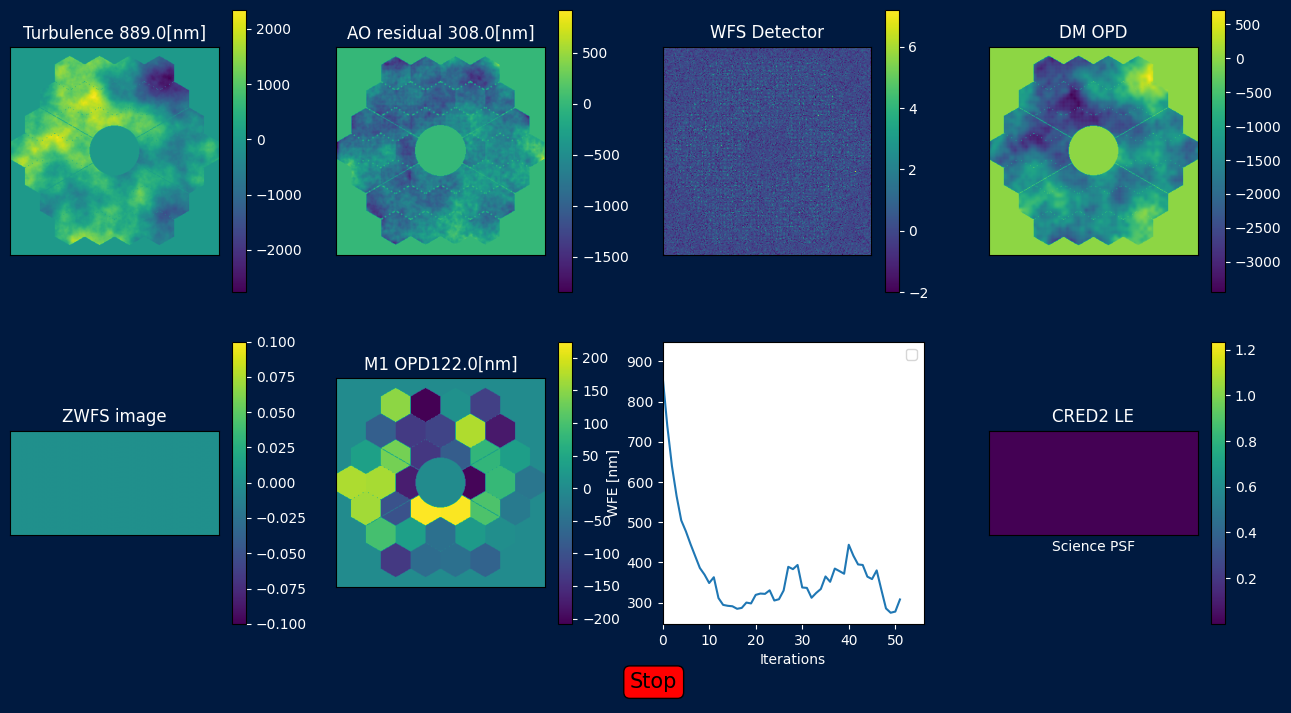

Loop51/100 Turbulence: 889.3314079086359 -- Residual:307.9997715645029 -- SR:0.45440693252791836

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop52/100 Turbulence: 889.9143315677936 -- Residual:298.5844906418896 -- SR:0.4765056465195594

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop53/100 Turbulence: 890.4834686178671 -- Residual:310.172080662257 -- SR:0.44936149559843214

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop54/100 Turbulence: 891.0553613843047 -- Residual:318.1527063093131 -- SR:0.4310113238866629

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop55/100 Turbulence: 891.6215084380339 -- Residual:271.9212296064662 -- SR:0.5407508345681268

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop56/100 Turbulence: 892.166897986228 -- Residual:299.46070427024637 -- SR:0.47443401950409486

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop57/100 Turbulence: 892.7034276565608 -- Residual:292.08162138073635 -- SR:0.4919693625268353

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop58/100 Turbulence: 893.2193911260366 -- Residual:304.0705158716443 -- SR:0.46358500034821065

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop59/100 Turbulence: 893.7297926357251 -- Residual:332.841891083684 -- SR:0.3980687063517446

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop60/100 Turbulence: 894.229044831775 -- Residual:308.35654314260216 -- SR:0.4535768613089935

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop61/100 Turbulence: 894.7291104242097 -- Residual:350.20962356751585 -- SR:0.3606785667680826

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop62/100 Turbulence: 895.2388788062392 -- Residual:388.1290332857464 -- SR:0.2857731078050311

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop63/100 Turbulence: 895.7385951461429 -- Residual:393.21553335737383 -- SR:0.2764840343882069

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop64/100 Turbulence: 896.241009072165 -- Residual:454.77296834605795 -- SR:0.17913273530523152

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop65/100 Turbulence: 896.7309950774027 -- Residual:409.69829558199723 -- SR:0.2476743286975716

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop66/100 Turbulence: 897.2090703405133 -- Residual:395.0985859048635 -- SR:0.2730924730836639

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop67/100 Turbulence: 897.6732730892802 -- Residual:371.75322287882045 -- SR:0.31692443992630964

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop68/100 Turbulence: 898.1258999909797 -- Residual:285.8272485554436 -- SR:0.5069789493923444

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop69/100 Turbulence: 898.5846658752199 -- Residual:321.5419747386388 -- SR:0.42331108807657497

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop70/100 Turbulence: 899.0294374285743 -- Residual:353.7209198337494 -- SR:0.3533417470609479

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop71/100 Turbulence: 899.474560614742 -- Residual:348.10640603043106 -- SR:0.36511012321296427

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop72/100 Turbulence: 899.9154488702051 -- Residual:317.13363312668776 -- SR:0.43333769107143727

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop73/100 Turbulence: 900.3465608023133 -- Residual:322.86935208309603 -- SR:0.42031110357141455

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop74/100 Turbulence: 900.7732924744355 -- Residual:375.12667594881674 -- SR:0.31035413844026466

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop75/100 Turbulence: 901.1835913693561 -- Residual:347.0471444763302 -- SR:0.3673523692729023

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop76/100 Turbulence: 901.5898422041132 -- Residual:324.9278343267975 -- SR:0.41567666704450756

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop77/100 Turbulence: 901.9724152898333 -- Residual:369.3648911654564 -- SR:0.32162319509121506

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop78/100 Turbulence: 902.3381149578996 -- Residual:346.8608743264442 -- SR:0.3677473779924177

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop79/100 Turbulence: 902.7013295361808 -- Residual:334.02453300359434 -- SR:0.3954669161584259

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop80/100 Turbulence: 903.0539973839105 -- Residual:358.02956056985863 -- SR:0.34444598550965333

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop81/100 Turbulence: 903.4114155360885 -- Residual:378.9749472755661 -- SR:0.30295520110671575

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop82/100 Turbulence: 903.7655711841871 -- Residual:357.0214499578518 -- SR:0.34651666921896124

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop83/100 Turbulence: 904.1246545827785 -- Residual:341.94626504222504 -- SR:0.3782454095640641

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop84/100 Turbulence: 904.4747473803257 -- Residual:303.5102499264718 -- SR:0.46489897699492677

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop85/100 Turbulence: 904.8032531551441 -- Residual:329.6981454070161 -- SR:0.4050226135488943

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop86/100 Turbulence: 905.1251193873119 -- Residual:308.03453352830695 -- SR:0.45432603024785595

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop87/100 Turbulence: 905.4291887674472 -- Residual:325.9434042164757 -- SR:0.41339835652047296

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop88/100 Turbulence: 905.7325493046544 -- Residual:316.2777954078909 -- SR:0.4352953101475411

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop89/100 Turbulence: 906.0354458962471 -- Residual:311.24222266820425 -- SR:0.4468837102722893

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop90/100 Turbulence: 906.3418044665751 -- Residual:276.8495209298395 -- SR:0.5287266412411777

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop91/100 Turbulence: 906.6506348633483 -- Residual:322.5639453867086 -- SR:0.42100055235714456

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop92/100 Turbulence: 906.9444475834374 -- Residual:360.20981612255014 -- SR:0.33999025664511684

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop93/100 Turbulence: 907.2406931694787 -- Residual:360.9735571220167 -- SR:0.33843676304474835

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop94/100 Turbulence: 907.5206603631458 -- Residual:375.3981073395645 -- SR:0.30982889556781795

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop95/100 Turbulence: 907.7839288473444 -- Residual:372.19602626029734 -- SR:0.3160575566884937

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop96/100 Turbulence: 908.0362936033179 -- Residual:327.99218886177295 -- SR:0.4088187456012884

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop97/100 Turbulence: 908.2751194808294 -- Residual:347.8076935363349 -- SR:0.3657417398404739

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop98/100 Turbulence: 908.5127071261359 -- Residual:305.163801085854 -- SR:0.4610247027416019

OOPAO Warning: 
Some subapertures are giving nan values!


<Figure size 640x480 with 0 Axes>

Loop99/100 Turbulence: 908.7349053412141 -- Residual:290.9270884118176 -- SR:0.4947304526083516

Average SR =  39.310117637520115
Telescope and Atmosphere separated!


In [57]:
KAO.param['print_display'] =True
KAO.param['nLoop']=100
KAO.param['magnitude_guide']=12

KAO.param['gainCL'] = 0.3
KAO.param['print_display'] =True
KAO.param['display_loop']=True

AO_output, Lpsf, Lcoro = close_loop(KAO,ZWFS_param, 1, atm_seed=42)

In [42]:
print(datetime)
print(type(datetime))

<module 'datetime' from '/opt/anaconda3/envs/oopao/lib/python3.9/datetime.py'>
<class 'module'>


/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_16544/3674117366.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 0, 'Iterations')

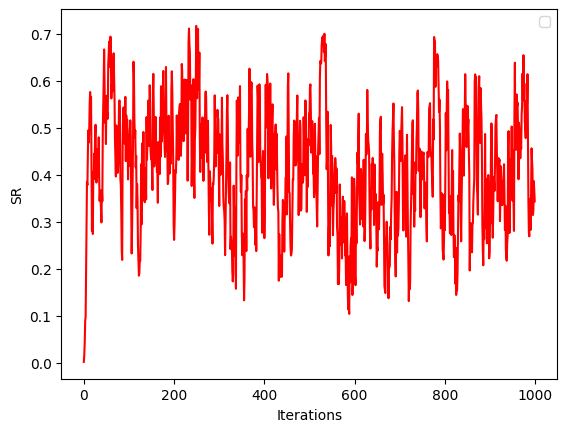

In [24]:
plt.figure()
plt.plot(AO_output['SR'],'r')
plt.legend()
plt.ylabel('SR')
plt.xlabel('Iterations')

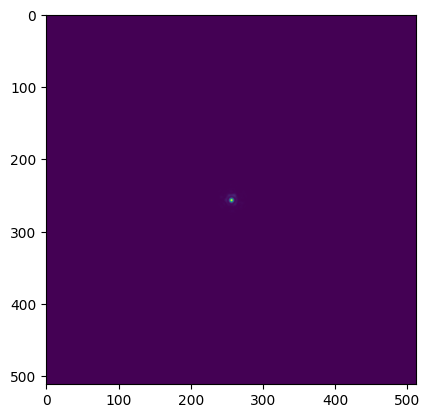

In [25]:
plt.imshow(AO_output['PSF_LE'])

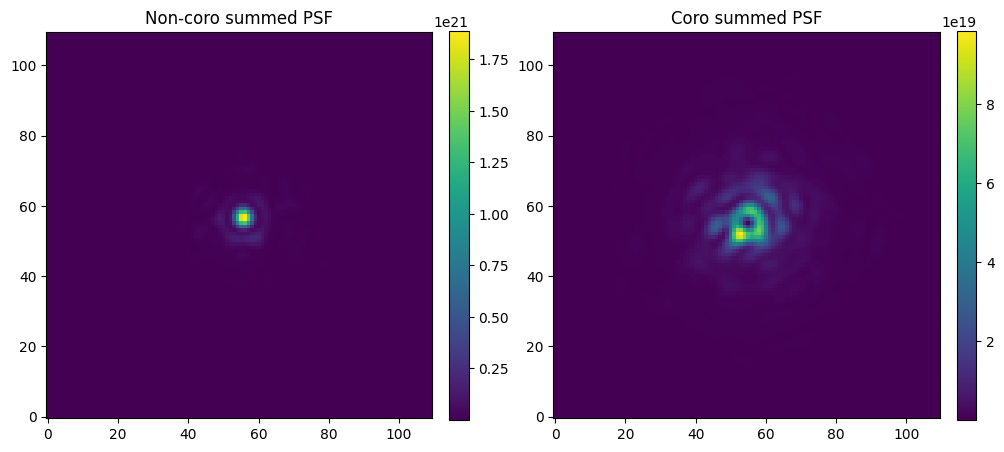

'\nf1 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_coro_240nm_mag5_1759662621887816_20s_sum.fits"\nf2 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_psf_240nm_mag5_1759662621887816_20s_sum.fits"\n\nd1 = fits.getdata(f1)\nd2 = fits.getdata(f2)\n\nfig, axs = plt.subplots(1, 2, figsize=(12,6))\n\nim2 = axs[0].imshow(d2, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())\nfig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)\naxs[0].set_title("Non-Coronagraphic PSF")\n\nim1 = axs[1].imshow(d1, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())\nfig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)\naxs[1].set_title("Coronagraphic PSF")\n\nplt.tight_layout()\nplt.show()\n'

In [26]:
psf_sum =Lpsf
coro_sum = Lcoro

fig, axes = plt.subplots(1, 2, figsize=(12,6))
im1=axes[0].imshow(psf_sum, origin="lower", cmap="viridis")
axes[0].set_title("Non-coro summed PSF")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
im2 = axes[1].imshow(coro_sum, origin="lower", cmap="viridis")
axes[1].set_title("Coro summed PSF")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.show()
'''
f1 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_coro_240nm_mag5_1759662621887816_20s_sum.fits"
f2 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_psf_240nm_mag5_1759662621887816_20s_sum.fits"

d1 = fits.getdata(f1)
d2 = fits.getdata(f2)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

im2 = axs[0].imshow(d2, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("Non-Coronagraphic PSF")

im1 = axs[1].imshow(d1, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("Coronagraphic PSF")

plt.tight_layout()
plt.show()
'''

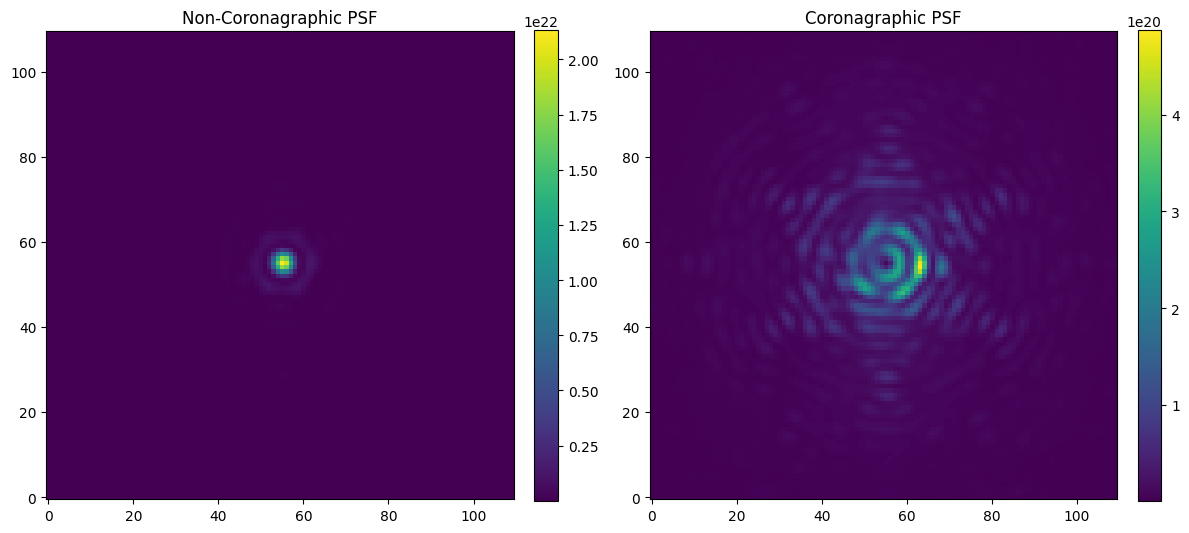

In [6]:
f1 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_coro_120nm_mag5_1759719033925917_20s_sum.fits"
f2 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_psf_120nm_mag5_1759719033925917_20s_sum.fits"

d1 = fits.getdata(f1)
d2 = fits.getdata(f2)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

im2 = axs[0].imshow(d2, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("Non-Coronagraphic PSF")

im1 = axs[1].imshow(d1, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("Coronagraphic PSF")



plt.tight_layout()
plt.show()